<a href="https://colab.research.google.com/github/Omer-code/COE451_Project_211/blob/main/Demand_Forecasting_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [245]:
import pandas as pd 
import numpy as np          # For mathematical calculations 
import matplotlib.pyplot as plt  # For plotting graphs 
from datetime import datetime    # To access datetime 
from pandas import Series        # To work on series 
%matplotlib inline 
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")

In [246]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [247]:
df_day = pd.read_csv('/content/query_result_Daily_02.38Z.csv')

# Cleaning and EDA

In [248]:
df_day.head()

,Suborder → Created At,Sum of Quantity
0,2020-12-05,160
1,2020-12-06,220
2,2020-12-10,160
3,2020-12-12,20
4,2020-12-13,130


In [249]:
df_day.rename(columns = {'Suborder → Created At':'date', 'Sum of Quantity':'quantity'}, inplace = True)

In [250]:
df_day.head()

,date,quantity
0,2020-12-05,160
1,2020-12-06,220
2,2020-12-10,160
3,2020-12-12,20
4,2020-12-13,130


In [251]:
df_day["date"] = pd.to_datetime(df_day["date"])
df_day.set_index("date",inplace=True)

# starting & eding dates 

print(df_day.index.min())
print(df_day.index.max())

2020-12-05 00:00:00
2022-08-01 00:00:00


In [252]:
df_day.index.max()- df_day.index.min()

Timedelta('604 days 00:00:00')

In [253]:
dtr =pd.date_range(df_day.index.min(), df_day.index.max(), freq='D')
s = pd.Series(index=dtr)
df = pd.concat([df_day,s[~s.index.isin(df_day.index)]]).sort_index()
df_day_2 = df.drop([0],axis=1).fillna(0)

df_day_2

,quantity
2020-12-05,160.0
2020-12-06,220.0
2020-12-07,0.0
2020-12-08,0.0
2020-12-09,0.0
...,...
2022-07-28,30.0
2022-07-29,40.0
2022-07-30,60.0
2022-07-31,40.0


In [254]:
df_day_2.head()

,quantity
2020-12-05,160.0
2020-12-06,220.0
2020-12-07,0.0
2020-12-08,0.0
2020-12-09,0.0


In [255]:
df_day_2.describe()

,quantity
count,605.000000
mean,89.504132
std,121.669208
min,0.000000
25%,20.000000
50%,60.000000
75%,110.000000
max,1950.000000


In [256]:
df_day_2.isna().sum()

quantity    0
dtype: int64

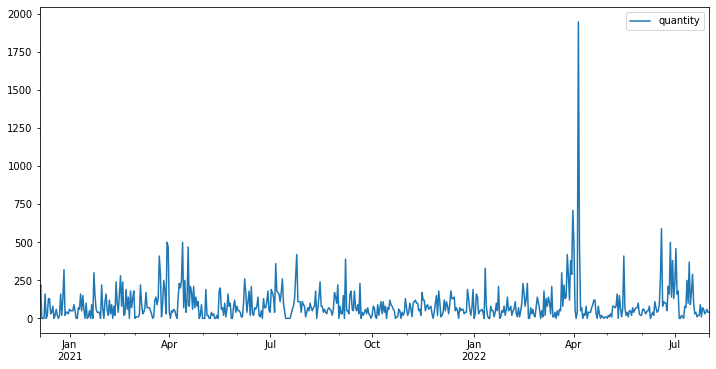

In [257]:
df_day_2.plot(figsize=(12, 6))

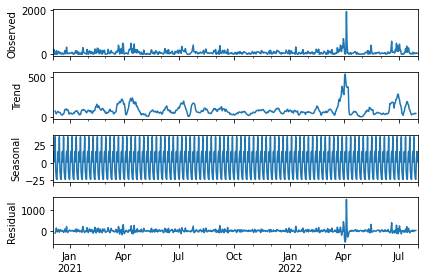

In [258]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(df_day_2, model="additive")
decompose_data.plot();

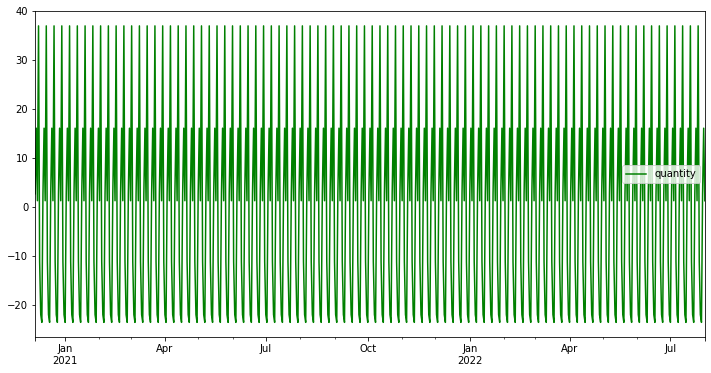

In [259]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green',figsize=(12, 6))

In [260]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df_day_2.quantity, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -7.474790268860249
2. P-Value :  4.9462946257930105e-11
3. Num Of Lags :  4
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 600
5. Critical Values :
	 1% :  -3.4412958288564814
	 5% :  -2.8663691131481484
	 10% :  -2.5693418027777777


p-value < 0.05, therfore the data is stationary.

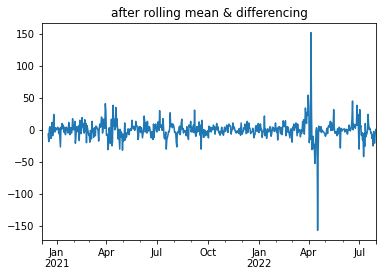

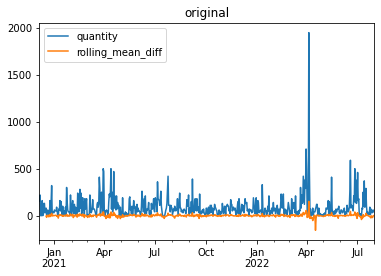

In [261]:
rolling_mean = df_day_2.rolling(window = 12).mean()
df_day_2['rolling_mean_diff'] = rolling_mean -rolling_mean.shift()
ax1 = plt.subplot()
df_day_2['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
df_day_2.plot(title='original');

# Modeling 

## ARIMA model

In [262]:
from statsmodels.tsa.arima_model import ARIMA

model=ARIMA(df_day_2.quantity,order=(1,1,1))
history=model.fit()

In [263]:
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.quantity   No. Observations:                  604
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3739.638
Method:                       css-mle   S.D. of innovations            117.644
Date:                Wed, 03 Aug 2022   AIC                           7487.276
Time:                        13:33:40   BIC                           7504.890
Sample:                    12-06-2020   HQIC                          7494.131
                         - 08-01-2022                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0275      0.037      0.752      0.453      -0.044       0.099
ar.L1.D.quantity     0.2539      0.039      6.442      0.000       0.177       0.331
ma.L1.D.quantity    -1.0000      0.006   -161.671      0.000      -1.012      -0.988
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.9383           +0.0000j            3.9383            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

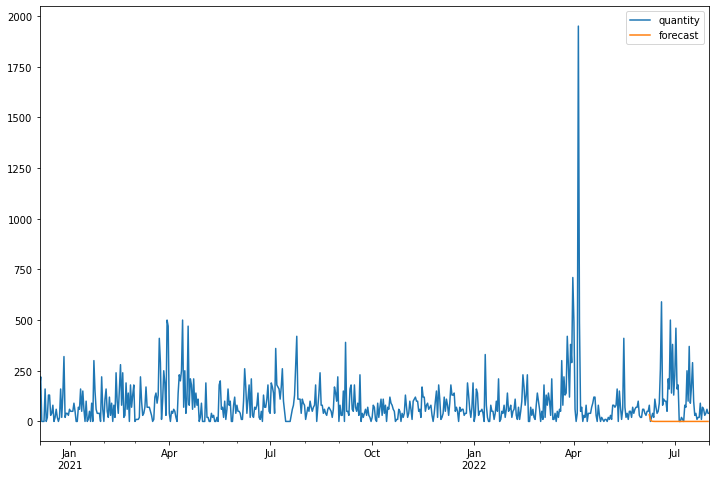

In [264]:
df_day_2['forecast']=history.predict(start=550,end=603,dynamic=True)
df_day_2[['quantity','forecast']].plot(figsize=(12,8))

In [265]:
model=ARIMA(df_day_2['rolling_mean_diff'].dropna(),order=(1,1,1))
model_fit=model.fit()

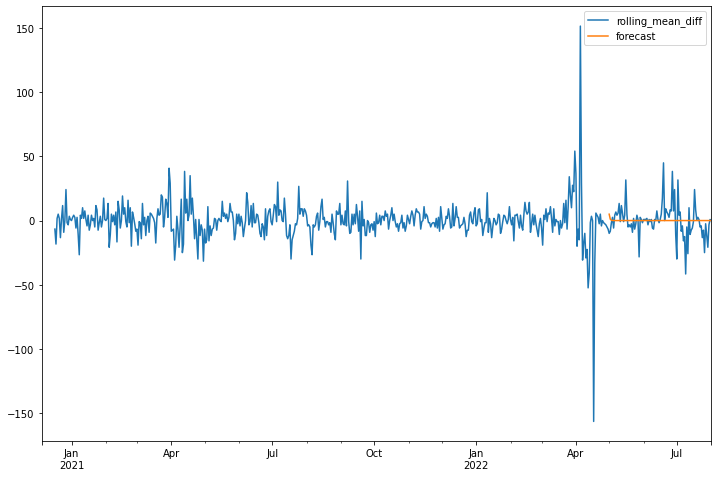

In [266]:
df_day_2['forecast']=model_fit.predict(start=500,end=603,dynamic=True)
df_day_2[['rolling_mean_diff','forecast']].plot(figsize=(12,8))

## SARIMAX

In [267]:
import statsmodels.api as sm

In [268]:
model=sm.tsa.statespace.SARIMAX(df_day_2.quantity,order=(5, 1, 1),seasonal_order=(1,1,1,90))
results=model.fit()

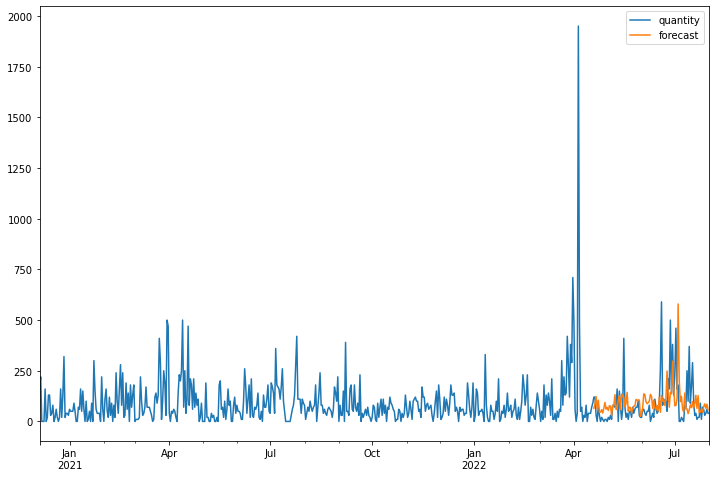

In [269]:
df_day_2['forecast']=results.predict(start=500,end=603,dynamic=True)
df_day_2[['quantity','forecast']].plot(figsize=(12,8))

In [270]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [271]:
test_real = df_day_2.iloc[500:603]
test_real

,quantity,rolling_mean_diff,forecast
2022-04-19,120.0,5.833333,65.261465
2022-04-20,120.0,4.166667,85.375115
2022-04-21,30.0,2.500000,122.897206
2022-04-22,0.0,-2.500000,60.059726
2022-04-23,80.0,5.000000,104.766771
...,...,...,...
2022-07-26,70.0,-25.000000,45.654183
2022-07-27,60.0,-2.500000,72.925159
2022-07-28,30.0,-11.666667,86.407319
2022-07-29,40.0,-20.833333,64.660217


In [272]:
MSE_ARIMA = mean_squared_error(test_real["quantity"], test_real["forecast"])
MAE_ARIMA = mean_absolute_error(test_real["quantity"], test_real["forecast"])

print("MSE= ", MSE_ARIMA,"\nMAE =", MAE_ARIMA)

MSE=  13020.80587323126 
MAE = 73.36508430770792


In [273]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [274]:
MAPE_ARIMA = MAPE(test_real["quantity"], test_real["forecast"])
print(MAPE_ARIMA)

inf


In [275]:
from pandas.tseries.offsets import DateOffset
pred_date=[df_day_2.index[-1]+ DateOffset(days=x)for x in range(0,100)]

In [276]:
pred_date=pd.DataFrame(index=pred_date[1:],columns=df_day_2.columns)
pred_date

,quantity,rolling_mean_diff,forecast
2022-08-02,NaN,NaN,NaN
2022-08-03,NaN,NaN,NaN
2022-08-04,NaN,NaN,NaN
2022-08-05,NaN,NaN,NaN
2022-08-06,NaN,NaN,NaN
...,...,...,...
2022-11-04,NaN,NaN,NaN
2022-11-05,NaN,NaN,NaN
2022-11-06,NaN,NaN,NaN
2022-11-07,NaN,NaN,NaN


In [277]:
final_df=pd.concat([df_day_2,pred_date])

In [278]:
len(final_df)

704

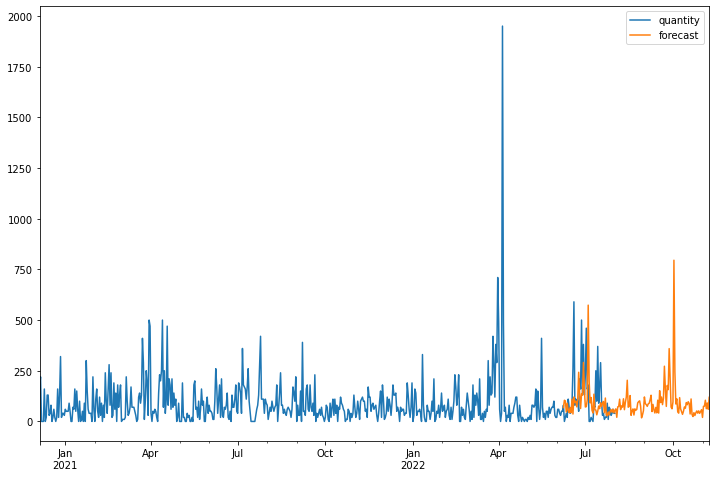

In [279]:
final_df['forecast'] = results.predict(start = 550, end = len(final_df), dynamic= True)  
final_df[['quantity', 'forecast']].plot(figsize=(12, 8))

In [280]:
final_df.tail(100)

,quantity,rolling_mean_diff,forecast
2022-08-01,40.0,0.0,55.131651
2022-08-02,NaN,NaN,61.923497
2022-08-03,NaN,NaN,20.383104
2022-08-04,NaN,NaN,71.973833
2022-08-05,NaN,NaN,72.969019
...,...,...,...
2022-11-04,NaN,NaN,104.580068
2022-11-05,NaN,NaN,62.817868
2022-11-06,NaN,NaN,91.115664
2022-11-07,NaN,NaN,60.219646


In [281]:
test_real2 = final_df.iloc[550:603]
test_real2

,quantity,rolling_mean_diff,forecast
2022-06-08,80.0,0.833333,68.297878
2022-06-09,0.0,-5.833333,104.534012
2022-06-10,20.0,-6.666667,100.770569
2022-06-11,40.0,0.833333,46.774078
2022-06-12,20.0,0.000000,89.810333
2022-06-13,110.0,7.500000,53.542806
2022-06-14,70.0,0.833333,43.582009
2022-06-15,40.0,-1.666667,68.231254
2022-06-16,50.0,0.833333,42.696708
2022-06-17,90.0,5.000000,110.044396


In [282]:
MSE_ARIMA = mean_squared_error(test_real2["quantity"], test_real2["forecast"])
MAE_ARIMA = mean_absolute_error(test_real2["quantity"], test_real2["forecast"])

print("MSE= ", MSE_ARIMA,"\nMAE =", MAE_ARIMA)

MSE=  20913.260151185117 
MAE = 92.8060794515122


In [283]:
MAPE_ARIMA = MAPE(test_real2["quantity"], test_real2["forecast"])
print(MAPE_ARIMA)

inf
